### Import packages

In [2]:
import pyemma as py
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.stats import pearsonr

### Import distances

In [ ]:
# import distances:
load_path = '../'
# WT:
which_system = '1m47_c125s'
distances_data_wt = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV.npy')
WT_resis     = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV_resis.npy', allow_pickle=True)
pdb_path = f'/Users/ssolieva/Desktop/bowman_lab/projects/IL2/simulations/IL2_simulations_{which_system}/{which_system}-prot-masses.pdb'
top_file = md.load(pdb_path) # load in the pdb file
# S15
which_system = 'seq15_c125s'
distances_data_s15 = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV.npy')
S15_resis     = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV_resis.npy', allow_pickle=True)
# S1
which_system = 'seq1_c123s'
distances_data_s1 = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV.npy')
S1_resis     = np.load(f'{load_path}data/system_{which_system}_distances_cpmg_ILV_resis.npy', allow_pickle=True)

## tICA

### tica: calculation

In [ ]:
# tica calculation:
distances_data_all = np.concatenate([distances_data_wt,distances_data_s15,distances_data_s1])
tica = py.coordinates.tica(list(distances_data_all), lag=50)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

### tica: maps

#### WT+seq1+seq15

In [ ]:
# tica map:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes, logscale=True)
axes.set_xlabel('IC1', fontsize=14)
axes.set_ylabel('IC2', fontsize=14)
plt.title("tICA built using ILV cpmg resis distances", fontsize=14)
#plt.savefig('../figures/c125s_tica_IC1_IC2.png', dpi=300)
fig.tight_layout()
plt.show()

#### Each system projected separately

In [4]:
# project each system separately
def generate_tica_plot(IC1_data, IC2_data, title, scatter_point1, scatter_point2):
    plt.figure(figsize=[4,4])
    plt.hexbin(IC1_data, IC2_data, bins='log', cmap='inferno')
    plt.title(title, fontsize=20, weight='bold')
    plt.xlabel("IC1", fontsize=18, weight='bold')
    plt.ylabel("IC2", fontsize=18, weight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(-5,2)
    plt.xlim(-4,4)
    plt.tight_layout()
    plt.savefig(f'../figures/c125s_tica_{title}.png')
    plt.show()
ic1 = tica_concatenated[:, 0:1]
ic2 = tica_concatenated[:, 1:2]
generate_tica_plot(ic1[:250100],         ic2[:250100],        'WT_c125s',  [0,0.85],    [1.2,-1])
generate_tica_plot(ic1[250100:250100*2], ic2[250100:250100*2],'S15_c125s', [0.25,0.85], [2.5,-2])
generate_tica_plot(ic1[250100*2:],       ic2[250100*2:],      'S1_c123s',  [-0.3,0.85], [-1.2,-1])

plt.figure(figsize=[4,4])
plt.scatter(ic1[250100:250100*2],ic2[250100:250100*2],color='#5AC8E0', label='S15')
plt.scatter(ic1[0:250100],       ic2[0:250100],       color='#888985', label='WT')
plt.scatter(ic1[250100*2:],      ic2[250100*2:],      color='#BC60A5', label='S1')
plt.title("Combined", fontsize=20, weight='bold')
plt.xlabel("IC1", fontsize=18, weight='bold')
plt.ylabel("IC2", fontsize=18, weight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-5,2)
plt.xlim(-4,4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f'../figures/c125s_tica_all.png')
plt.show()

NameError: name 'tica_concatenated' is not defined

### tica: top features

#### Calculate top features

In [ ]:
# make atom pairs
IL_WT_S15_resin = '12 14 17 18 19 21 24 25 36 40 53 59 63 66 70 89 94 96 114 118 122 128 129 132'
V_WT_S15_resin  = '91 93'
IL_S1_resin     = '12 14 17 18 19 21 24 25 36 40 53 59 63 66 70 87 92 94 112 116 120 126 127 130'
V_S1_resin      = '89 91'
atom_indices_IL = top_file.topology.select(f'residue {IL_WT_S15_resin} and name CD1')
atom_indices_V = top_file.topology.select(f'residue {V_WT_S15_resin} and name CG1')
atom_indices1 = np.unique(np.concatenate([atom_indices_IL, atom_indices_V])) # put in order
atom_indices = np.unique(atom_indices1)
atom_pairs = list(itertools.combinations(atom_indices, 2))
print(len(atom_pairs))
resi_n_names = []
for i in range(len(atom_indices1)):
    resi_n_names.append(top_file.topology.atom(atom_indices[i]).residue)
print(resi_n_names)
distances_feat = py.coordinates.featurizer(top_file)
distances_feat.add_distances(atom_pairs)
pairs_of_resis = list(distances_feat.describe())

# find top features 
r2 = np.transpose(np.concatenate(distances_data_all, axis = 0))
print('TOP FEATURES FOR TICA PLOT (COMBINED WT S1 and S15 SIMULATIONS)')
print("(number of features, values): ", r2.shape)
# for each feature, find its standard deviation
standard_deviations = []
for i in range(len(r2)):
    standard_deviations.append(np.std(r2[i]))
V = tica.eigenvectors
tIC1 = V[:,0]
tIC2 = V[:,1]
normalized_tIC1 = tIC1 * standard_deviations
normalized_tIC2 = tIC2 * standard_deviations
# save normalized tICs:
normalized_tIC_list = [normalized_tIC1,normalized_tIC2]
t=5 # how many features to print out
tICs_list_for_feature_printing = [normalized_tIC1,normalized_tIC2,]
for c in range(2):
    top_features = np.argsort(-np.abs(tICs_list_for_feature_printing[c]))
    print("\nIC",c+1, top_features[0:t])
    for i in range(t):
        which_pair = top_features[i]
        print(i, list(distances_feat.describe())[which_pair])


#### Plot top features

In [ ]:
plt.figure(figsize=[15,2])
plt.bar(np.arange(len(normalized_tIC1)), normalized_tIC1, color='blue')
#plt.scatter([201,133,48,43,257], bar_points)
plt.xlabel('residue pair', fontsize=10, weight='bold')
plt.xticks(np.arange(0, len(normalized_tIC1), 20))
plt.title('normalized IC1 values', fontsize=10, weight='bold')
plt.tight_layout()
plt.savefig('../figures/c125s_normalized_IC1.png')
plt.show()

plt.figure(figsize=[15,2])
plt.bar(np.arange(len(normalized_tIC2)), normalized_tIC2, color='purple')
plt.xlabel('residue pair', fontsize=10, weight='bold')
plt.xticks(np.arange(0, len(normalized_tIC2), 20))
plt.title('normalized IC2 values', fontsize=10, weight='bold')
plt.tight_layout()
plt.savefig('../figures/c125s_normalized_IC2.png')
plt.show()

plt.figure(figsize=[15,2])
plt.bar(np.arange(len(normalized_tIC1)), normalized_tIC1, color='gray')
for i in range(len(normalized_tIC1)):
    if np.abs(normalized_tIC1[i]) > 0.15:
       plt.scatter(i,normalized_tIC1[i],color='r') 

plt.xlabel('residue pair', fontsize=10, weight='bold')
plt.xticks(np.arange(0, len(normalized_tIC1), 20))
plt.title('normalized IC1 values', fontsize=10, weight='bold')
plt.tight_layout()
#plt.savefig('../figures/c125s_normalized_IC1.png')
plt.show()

plt.figure(figsize=[15,2])
plt.bar(np.arange(len(normalized_tIC2)), normalized_tIC2, color='lightgray')
for i in range(len(normalized_tIC2)):
    if np.abs(normalized_tIC2[i]) > 0.15:
       plt.scatter(i,normalized_tIC2[i],color='r') 
plt.xlabel('residue pair', fontsize=10, weight='bold')
plt.xticks(np.arange(0, len(normalized_tIC2), 20))
plt.title('normalized IC2 values', fontsize=10, weight='bold')
plt.tight_layout()
#plt.savefig('../figures/c125s_normalized_IC1.png')
plt.show()

for c in range(240,270):
    print(c, list(distances_feat.describe())[c])

## plot distance distributions

266 DIST: LEU 70 CD1 1171 - ILE 122 CD1 2023


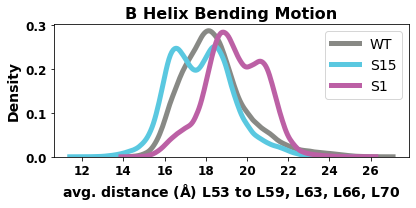

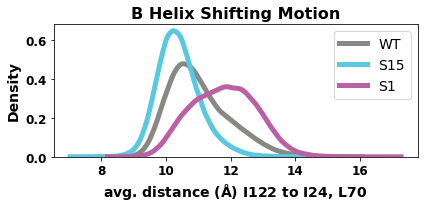

In [4]:
r2_wt = np.transpose(np.concatenate(distances_data_wt, axis=0))
r2_s15= np.transpose(np.concatenate(distances_data_s15, axis=0))
r2_s1 = np.transpose(np.concatenate(distances_data_s1,  axis=0))

for i in range(266,267):
    print(i, list(distances_feat.describe())[i])
    
WT_B_bending = np.mean([r2_wt[205], r2_wt[206], r2_wt[207], r2_wt[208]], axis=0)
S15_B_bending= np.mean([r2_s15[205],r2_s15[206],r2_s15[207],r2_s15[208]],axis=0)
S1_B_bending = np.mean([r2_s1[205], r2_s1[206], r2_s1[207], r2_s1[208]], axis=0)

WT_B_shift =   np.mean([r2_wt[150], r2_wt[266]], axis=0)
S15_B_shift=   np.mean([r2_s15[150],r2_s15[266]],axis=0)
S1_B_shift=    np.mean([r2_s1[150], r2_s1[266]], axis=0)

plt.figure(figsize=[6,3])
angstrom = r'$\bf{\AA}$'
#resi1 = f'{list(distances_feat.describe())[which_pair][6:16]}'
#resi2 = f'{list(distances_feat.describe())[which_pair][23:33]}'
plt.title("B Helix Bending Motion",fontsize=16, weight='bold')
plt.xlabel(f"avg. distance ({angstrom}) L53 to L59, L63, L66, L70", fontsize=14, weight='bold')
plt.ylabel('Density',fontsize=14, weight='bold')
sns.kdeplot(WT_B_bending*10,  c='#888985', label='WT',   linewidth=5)
sns.kdeplot(S15_B_bending*10, c='#5AC8E0', label='S15',   linewidth=5)
sns.kdeplot(S1_B_bending*10,  c='#BC60A5', label='S1',   linewidth=5)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f'../figures/c125s_dist_pair_avg_205_206_207_208.pdf', transparent=True, dpi=300)
plt.show()

plt.figure(figsize=[6,3])
angstrom = r'$\bf{\AA}$'
#resi1 = f'{list(distances_feat.describe())[which_pair][6:16]}'
#resi2 = f'{list(distances_feat.describe())[which_pair][23:33]}'
plt.title("B Helix Shifting Motion",fontsize=16, weight='bold')
plt.xlabel(f"avg. distance ({angstrom}) I122 to I24, L70", fontsize=14, weight='bold')
plt.ylabel('Density',fontsize=14, weight='bold')
sns.kdeplot(WT_B_shift*10,  c='#888985', label='WT',   linewidth=5)
sns.kdeplot(S15_B_shift*10, c='#5AC8E0', label='S15',   linewidth=5)
sns.kdeplot(S1_B_shift*10,  c='#BC60A5', label='S1',   linewidth=5)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f'../figures/c125s_dist_pair_avg_150_266.pdf', transparent=True, dpi=300)
plt.show()